In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, AveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Activation, Flatten
import tensorflow_model_optimization as tfmot

In [2]:
with np.load('mnist.npz') as f:
    x_train, y_train = f['x_train'], f['y_train']

x_train = x_train/255 # Normalize pixel values to [0,1] and flatten each image to 1D.
y_train = keras.utils.to_categorical(y_train) # One-hot encoding

print('This is how a one-hot encoded 5 looks like')
print(y_train[0])

This is how a one-hot encoded 5 looks like
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [3]:
def create_base_model():
    raw_model = Sequential()
    raw_model.add(Conv2D(input_shape=(28, 28, 1), kernel_size=(16, 16), filters=32, strides=(4, 4), activation='relu'))
    raw_model.add(Conv2D(kernel_size=(3, 3), filters=64, strides=(1, 1), activation='relu'))
    raw_model.add(Flatten())
    raw_model.add(Dense(10, activation='softmax'))
    return raw_model

In [4]:
def create_lenet():
    lenet_5_model = Sequential([
        Conv2D(6, kernel_size=5, strides=1,  activation='tanh', input_shape=(28, 28, 1), padding='same'), #C1
        AveragePooling2D(), #S2
        Conv2D(16, kernel_size=5, strides=1, activation='tanh', padding='valid'), #C3
        AveragePooling2D(), #S4
        Flatten(), #Flatten
        Dense(120, activation='tanh'), #C5
        Dense(84, activation='tanh'), #F6
        Dense(10, activation='softmax') #Output layer
    ])
    return lenet_5_model

In [5]:
#model = create_base_model()
model = create_lenet()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

2022-01-12 17:18:27.713228: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2022-01-12 17:18:32.562772: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/5
118/118 [==============================] - 8s 61ms/step - loss: 0.8554 - accuracy: 0.7685
Epoch 2/5
118/118 [==============================] - 7s 59ms/step - loss: 0.2451 - accuracy: 0.9251
Epoch 3/5
118/118 [==============================] - 7s 60ms/step - loss: 0.1602 - accuracy: 0.9508
Epoch 4/5
118/118 [==============================] - 7s 60ms/step - loss: 0.1133 - accuracy: 0.9647
Epoch 5/5
118/118 [==============================] - 7s 62ms/step - loss: 0.0891 - accuracy: 0.9730


Text(0, 0.5, 'Accuracy')

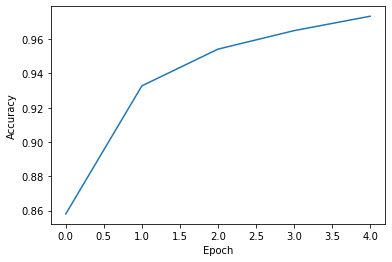

In [6]:
# Fit the model:
model.compile(optimizer='RMSprop',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
history = model.fit(x_train.reshape(-1,28,28,1), y_train, batch_size=512, epochs=5)
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Model prediction: 9


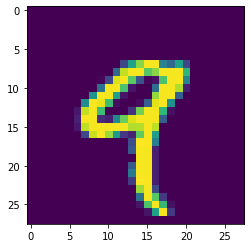

In [7]:
# classify image:
k = 4
image = x_train[k]
y_predict = np.argmax(model.predict(image[None, :,:, None]))

print("Model prediction:", y_predict)
plt.imshow(image.reshape(28, 28))

# Save the model

In [8]:
model.save("mnist.h5")

# Prune the model

In [85]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 512
epochs = 5
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = x_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

print("end_step:", end_step)

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.5,
                                                               final_sparsity=0.50,
                                                               begin_step=0,
                                                               end_step=end_step)
}

#raw_model = create_base_model()
raw_model = create_lenet()
#raw_model.load_weights(pretrained_weights)

model_pruned = prune_low_magnitude(raw_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_pruned.compile(loss='categorical_crossentropy', metrics=['accuracy'])

#model_for_pruning.summary()

end_step: 530


In [86]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  #tfmot.sparsity.keras.PruningSummaries(log_dir="log")
]

model_pruned.fit(x_train.reshape(-1,28,28,1), y_train,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)


#%tensorboard --logdir={"log"}

Epoch 1/5
106/106 [==============================] - 8s 64ms/step - loss: 0.8398 - accuracy: 0.7736 - val_loss: 0.2573 - val_accuracy: 0.9345
Epoch 2/5
106/106 [==============================] - 7s 62ms/step - loss: 0.2742 - accuracy: 0.9217 - val_loss: 0.1753 - val_accuracy: 0.9513
Epoch 3/5
106/106 [==============================] - 7s 62ms/step - loss: 0.1971 - accuracy: 0.9407 - val_loss: 0.1441 - val_accuracy: 0.9592
Epoch 4/5
106/106 [==============================] - 7s 63ms/step - loss: 0.1499 - accuracy: 0.9551 - val_loss: 0.1137 - val_accuracy: 0.9673
Epoch 5/5
106/106 [==============================] - 7s 63ms/step - loss: 0.1246 - accuracy: 0.9616 - val_loss: 0.1037 - val_accuracy: 0.9690


In [87]:
model_pruned_export = tfmot.sparsity.keras.strip_pruning(model_pruned)

In [88]:
total_weights = 0
total_weights_0 = 0

for idx, layer in enumerate(model_pruned.layers):
    weights_layer = 0
    weights_0 = 0
    
    if len(layer.weights) == 0:
        continue

    for weight in np.nditer(layer.weights):
        if type(weight) != tuple:
            continue

        weights_layer += 1
        if weight[0] == 0:
            weights_0 += 1

    print("Layer: ", idx, "Zero weights:", weights_0, "/", weights_layer)
    total_weights += weights_layer
    total_weights_0 += weights_0

print("Total 0-weights:", total_weights_0, "/", total_weights, " => ", (total_weights_0 / total_weights) * 100, "%")

Layer:  0 Zero weights: 75 / 150
Layer:  1 Zero weights: 0 / 0
Layer:  2 Zero weights: 1200 / 2400
Layer:  3 Zero weights: 0 / 0
Layer:  4 Zero weights: 0 / 0
Layer:  5 Zero weights: 24000 / 48000
Layer:  6 Zero weights: 5040 / 10080
Layer:  7 Zero weights: 420 / 840
Total 0-weights: 30735 / 61470  =>  50.0 %


# Quantize the model

In [9]:
def representative_dataset_gen():
  for i in range(100):
    yield [x_train[i].reshape(-1,28,28,1).astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model_pruned_export)
#converter = tf.lite.TFLiteConverter.from_keras_model(model)

# NOTE: The current version of TensorFlow appears to break the model when using optimizations
#    You can try uncommenting the following if you would like to generate a smaller size .tflite model
#converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_model = converter.convert()
open("model.tflite", "wb").write(tflite_model)

NameError: name 'model_pruned_export' is not defined

# Test the tflite model

In [90]:
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_quantization_parameters = input_details[0]['quantization_parameters']
output_quantization_parameters = output_details[0]['quantization_parameters']

print("== Input details ==")
print("name:", interpreter.get_input_details()[0]['name'])
print("shape:", interpreter.get_input_details()[0]['shape'])
print("type:", interpreter.get_input_details()[0]['dtype'])
print("quantization scale:", input_quantization_parameters['scales'])
print("quantization zero point:", input_quantization_parameters['zero_points'])

print("\n== Output details ==")
print("name:", interpreter.get_output_details()[0]['name'])
print("shape:", interpreter.get_output_details()[0]['shape'])
print("type:", interpreter.get_output_details()[0]['dtype'])
print("quantization scale:", output_quantization_parameters['scales'])
print("quantization zero point:", output_quantization_parameters['zero_points'])

print("\nDUMP INPUT")
print(interpreter.get_input_details()[0])
print("\nDUMP OUTPUT")
print(interpreter.get_output_details()[0])

== Input details ==
name: conv2d_48_input
shape: [ 1 28 28  1]
type: <class 'numpy.float32'>
quantization scale: []
quantization zero point: []

== Output details ==
name: Identity
shape: [ 1 10]
type: <class 'numpy.float32'>
quantization scale: []
quantization zero point: []

DUMP INPUT
{'name': 'conv2d_48_input', 'index': 25, 'shape': array([ 1, 28, 28,  1], dtype=int32), 'shape_signature': array([-1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}

DUMP OUTPUT
{'name': 'Identity', 'index': 26, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {

### Accuracy

In [91]:
def predict(interpreter, input_data):
    interpreter.set_tensor(input_details[0]["index"], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]["index"])
    return output_data


def measure_accuracy(interpreter, samples = len(x_train)):
    output_data = []

    for idx, sample in enumerate(x_train[:samples]):
        input_data = np.array(sample, dtype=np.float32)
        input_data = np.expand_dims(input_data, axis=0)
        input_data = np.expand_dims(input_data, axis=3)
        output_data.append(predict(interpreter, input_data))

    a = [np.argmax(y, axis=None, out=None) for y in output_data]
    b = [np.argmax(y, axis=None, out=None) for y in y_train[:samples]]

    accuracy = (np.array(a) == np.array(b)).mean()
    print("TFLite Accuracy:", accuracy)

In [92]:
measure_accuracy(interpreter, 1000)

TFLite Accuracy: 0.967


# Save .TFLite as C Array

In [97]:
import binascii

def convert_to_c_array(bytes) -> str:
  hexstr = binascii.hexlify(bytes).decode("UTF-8")
  hexstr = hexstr.upper()
  array = ["0x" + hexstr[i:i + 2] for i in range(0, len(hexstr), 2)]
  array = [array[i:i+10] for i in range(0, len(array), 10)]
  return ",\n  ".join([", ".join(e) for e in array])

tflite_binary = open("model.tflite", 'rb').read()
ascii_bytes = convert_to_c_array(tflite_binary)
c_file = "alignas(8) const unsigned char g_model[] = {\n  " + ascii_bytes + "\n};\nconst unsigned int g_model_len = " + str(len(tflite_binary)) + ";"
open("model.h", "w").write(c_file)

427540

# Convert test data to C array

In [11]:
k = 0
test_data = x_train[k]

print("Shape:", test_data.shape)

# float test_data[28][28] = {{0, 1, 2}, {0, 2, 3}};

def convert_to_float_c_array(data):
    res = "float test_data[28][28] = "
    rows = []
    for i, row in enumerate(data):
        string_row = [str(d) for d in row]
        rows.append(("{" + (", ".join(string_row)) + "}"))

    
    array_content = ("{" + (", ".join(rows)) + "}")
    res += array_content
    res += ";"
    return res

    
        


#convert_to_float_c_array([[1,2,3],[4,5,6],[7,8,9]])
convert_to_float_c_array(test_data)



Shape: (28, 28)


'float test_data[28][28] = {{0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0}, {0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0}, {0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0}, {0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0}, {0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0}, {0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011764705882352941, 0.07058823529411765, 0.07058823529411765, 0.07058823529411765, 0.49411764705882355, 0.5333333333333333, 0.6862745098039216, 0.10196078431372549, 0.6509803921568628, 1.0, 0.9686274